# Reliability Statistics and Predictive Calibration

## Load libraries

In [1]:
import os
import random

from io import StringIO

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from lifelines import KaplanMeierFitter, LogNormalFitter, WeibullFitter
from lifelines.utils import survival_table_from_events
from scipy.stats import binom, lognorm, norm, weibull_min

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Example failure distribution

In [3]:
mu, sigma = 6, 0.3

In [4]:
def plot_ln_pi(mu, sigma, xy=(700, 75), title="Exact Prediction Interval for Known Lognormal"):
    failure_dist = lognorm(s=sigma, scale=np.exp(mu))
    samples = failure_dist.rvs(size=1000, random_state=100)
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs = axs.flatten()
    axs[0].hist(samples, ec="black", color="slateblue", bins=30)
    axs[0].set_title(f"Failure Time Distribution: LN({mu}, {sigma})")
    count, bins_count = np.histogram(samples, bins=30)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs[1].plot(bins_count[1:], cdf, label="CDF", color="slateblue")
    axs[2].plot(bins_count[1:], 1 - cdf, label="Survival", color="slateblue")
    axs[2].legend()
    axs[1].legend()
    axs[1].set_title("Cumulative Density Function")
    axs[2].set_title("Survival Curve")

    lb = failure_dist.ppf(0.01)
    ub = failure_dist.ppf(0.99)
    axs[0].annotate(
        f"99% Prediction \nInterval: [{np.round(lb, 3)}, {np.round(ub, 3)}]",
        xy=(xy[0], xy[1] - 25),
        fontweight="bold",
    )
    axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label="p99 PI", color="cyan")
    axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p99 PI", color="cyan")
    axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p99 PI", color="cyan")
    lb = failure_dist.ppf(0.025)
    ub = failure_dist.ppf(0.975)
    axs[0].annotate(
        f"95% Prediction \nInterval: [{np.round(lb, 3)}, {np.round(ub, 3)}]",
        xy=(xy[0], xy[1]),
        fontweight="bold",
    )
    axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label="p95 PI", color="magenta")
    axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p95 PI", color="magenta")
    axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label="p95 PI", color="magenta")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.suptitle(title, fontsize=20)

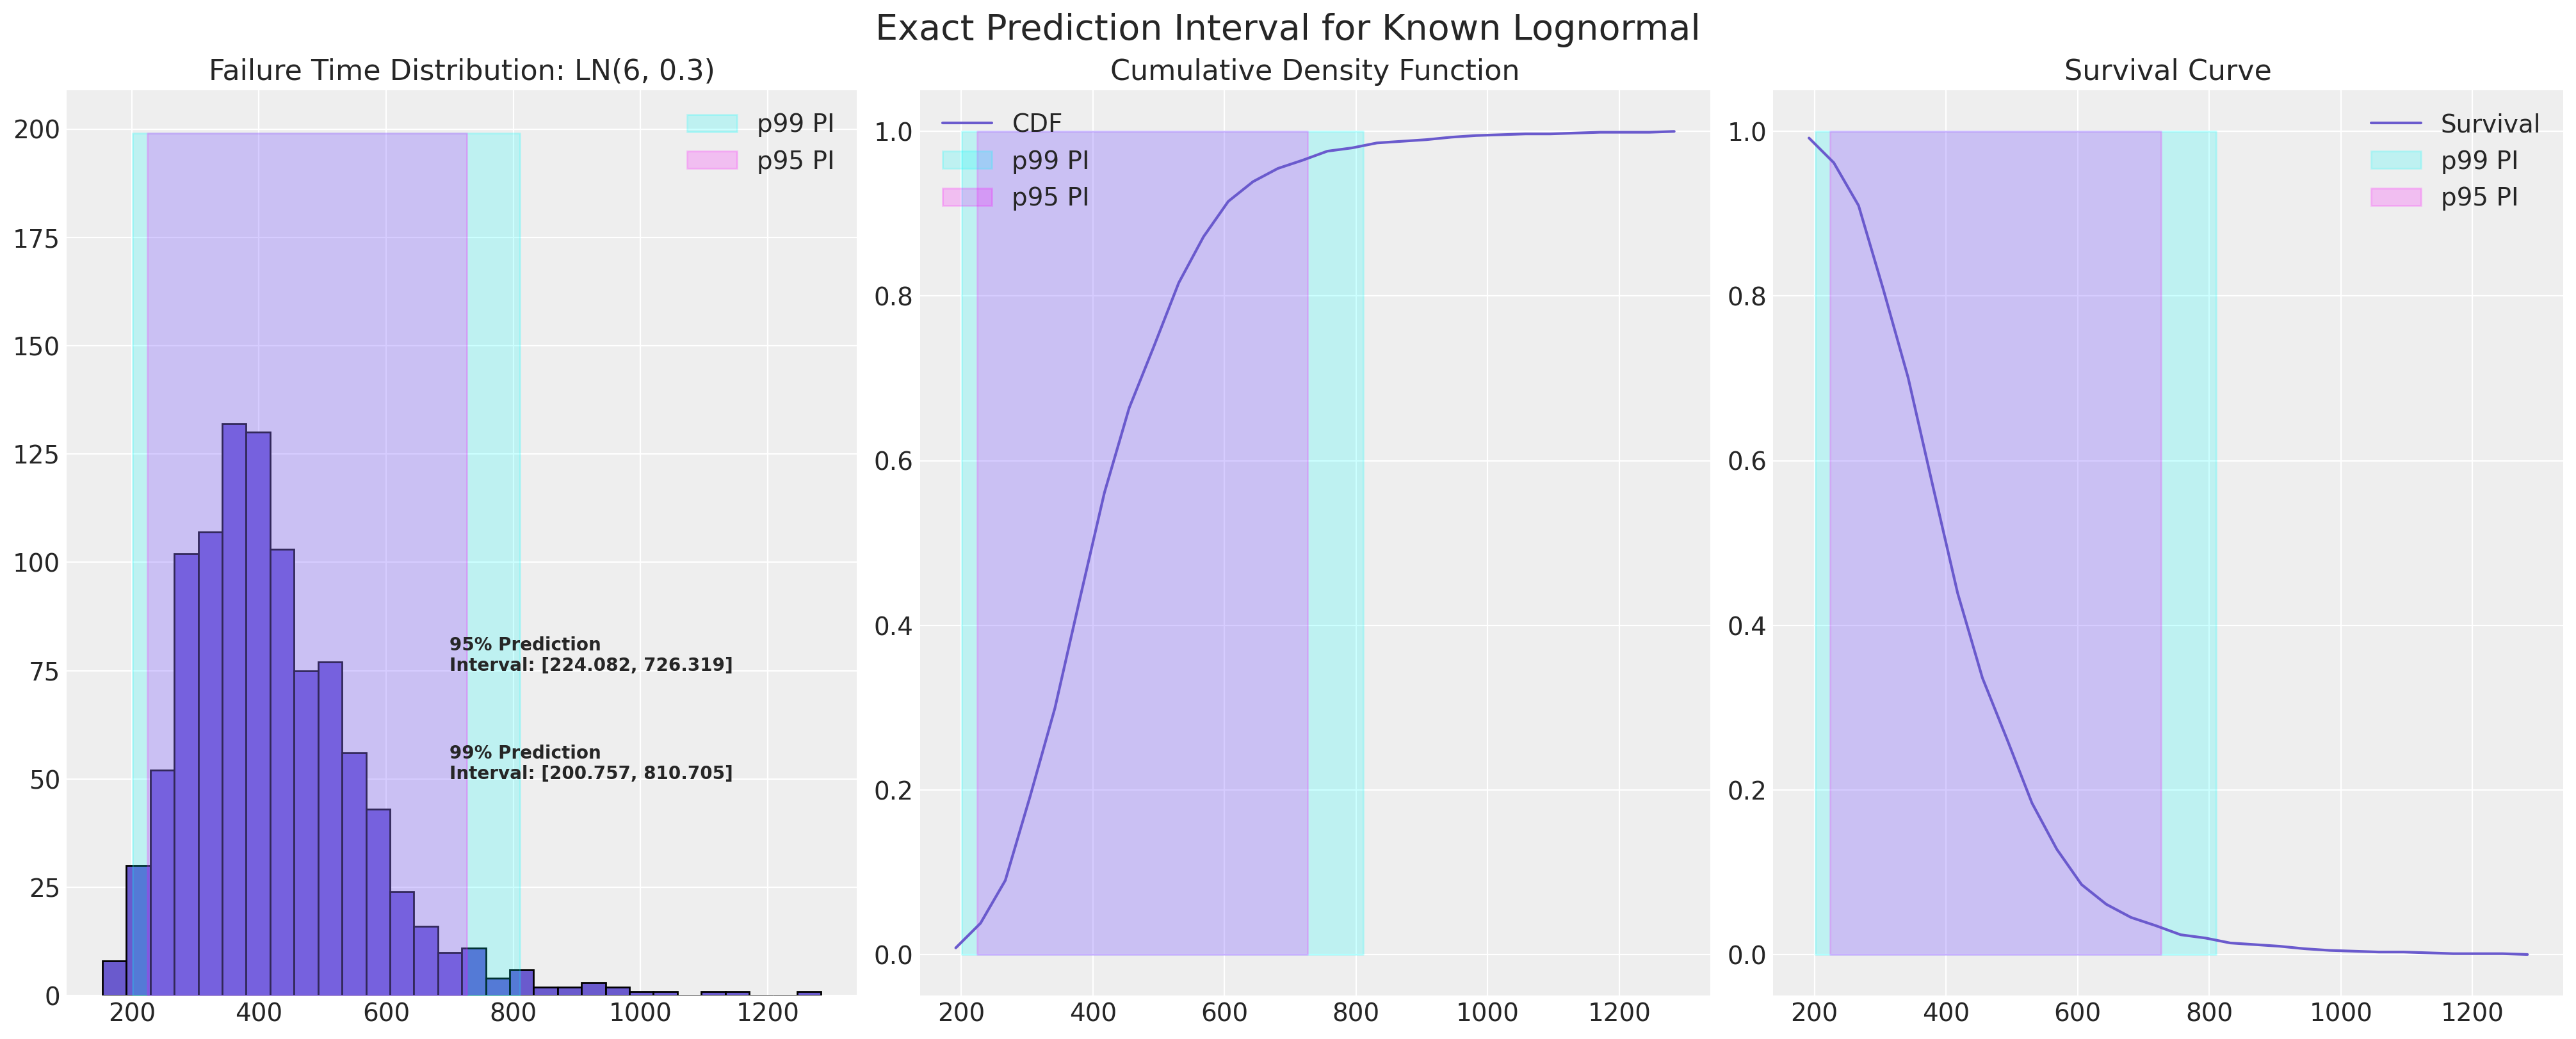

In [5]:
plot_ln_pi(mu, sigma)

## Estimate of the failure distribution from data

### Heat exchange data

#### Load data

In [6]:
heat_exchange_df = pd.read_csv(
    StringIO(
        """Years Lower,Years Upper,Censoring Indicator,Count,Plant
0,1,Left,1,1
1,2,Interval,2,1
2,3,Interval,2,1
3, ,Right,95,1
0,1,Left,2,2
1,2,Interval,3,2
2, ,Right,95,2
0,1,Left,1,3
1, ,Right,99,3

"""
    )
)

heat_exchange_df["year_interval"] = (
    heat_exchange_df["Years Lower"].astype(str) + "," + heat_exchange_df["Years Upper"].astype(str)
)
heat_exchange_df["failed"] = np.where(
    heat_exchange_df["Censoring Indicator"] != "Right", heat_exchange_df["Count"], 0
)
heat_exchange_df["censored"] = np.where(
    heat_exchange_df["Censoring Indicator"] == "Right", heat_exchange_df["Count"], 0
)
heat_exchange_df["risk_set"] = [100, 99, 97, 0, 100, 98, 0, 100, 0]

In [7]:
heat_exchange_df

Years Lower Years Upper Censoring Indicator  Count  Plant year_interval  \
0            0           1                Left      1      1           0,1   
1            1           2            Interval      2      1           1,2   
2            2           3            Interval      2      1           2,3   
3            3                           Right     95      1           3,    
4            0           1                Left      2      2           0,1   
5            1           2            Interval      3      2           1,2   
6            2                           Right     95      2           2,    
7            0           1                Left      1      3           0,1   
8            1                           Right     99      3           1,    

   failed  censored  risk_set  
0       1         0       100  
1       2         0        99  
2       2         0        97  
3       0        95         0  
4       2         0       100  
5       3         0        98  
6       0        95         0  
7       1         0       100  
8       0        99         0

In [8]:
actuarial_table = heat_exchange_df.groupby(["Years Upper"])[["failed", "risk_set"]].sum()
actuarial_table = actuarial_table.tail(3)

In [9]:
def greenwood_variance(df):
    ### Used to estimate the variance in the CDF
    n = len(df)
    ps = [df.iloc[i]["p_hat"] / (df.iloc[i]["risk_set"] * df.iloc[i]["1-p_hat"]) for i in range(n)]
    s = [(df.iloc[i]["S_hat"] ** 2) * np.sum(ps[0 : i + 1]) for i in range(n)]
    return s

In [10]:
def logit_transform_interval(df):
    ### Used for robustness in the estimation of the Confidence intervals in the CDF
    df["logit_CI_95_lb"] = df["F_hat"] / (
        df["F_hat"]
        + df["S_hat"] * np.exp((1.960 * df["Standard_Error"]) / (df["F_hat"] * df["S_hat"]))
    )
    df["logit_CI_95_ub"] = df["F_hat"] / (
        df["F_hat"]
        + df["S_hat"] / np.exp((1.960 * df["Standard_Error"]) / (df["F_hat"] * df["S_hat"]))
    )
    df["logit_CI_95_lb"] = np.where(df["logit_CI_95_lb"] < 0, 0, df["logit_CI_95_lb"])
    df["logit_CI_95_ub"] = np.where(df["logit_CI_95_ub"] > 1, 1, df["logit_CI_95_ub"])
    return df

In [11]:
def make_actuarial_table(actuarial_table):
    ### Actuarial lifetables are used to describe the nature of the risk over time and estimate
    actuarial_table["p_hat"] = actuarial_table["failed"] / actuarial_table["risk_set"]
    actuarial_table["1-p_hat"] = 1 - actuarial_table["p_hat"]
    actuarial_table["S_hat"] = actuarial_table["1-p_hat"].cumprod()
    actuarial_table["CH_hat"] = -np.log(actuarial_table["S_hat"])
    ### The Estimate of the CDF function
    actuarial_table["F_hat"] = 1 - actuarial_table["S_hat"]
    actuarial_table["V_hat"] = greenwood_variance(actuarial_table)
    actuarial_table["Standard_Error"] = np.sqrt(actuarial_table["V_hat"])
    actuarial_table["CI_95_lb"] = (
        actuarial_table["F_hat"] - actuarial_table["Standard_Error"] * 1.960
    )
    actuarial_table["CI_95_lb"] = np.where(
        actuarial_table["CI_95_lb"] < 0, 0, actuarial_table["CI_95_lb"]
    )
    actuarial_table["CI_95_ub"] = (
        actuarial_table["F_hat"] + actuarial_table["Standard_Error"] * 1.960
    )
    actuarial_table["CI_95_ub"] = np.where(
        actuarial_table["CI_95_ub"] > 1, 1, actuarial_table["CI_95_ub"]
    )
    actuarial_table["ploting_position"] = actuarial_table["F_hat"].rolling(1).median()
    actuarial_table = logit_transform_interval(actuarial_table)
    return actuarial_table

In [12]:
actuarial_table_heat = make_actuarial_table(actuarial_table)
actuarial_table_heat = actuarial_table_heat.reset_index()
actuarial_table_heat.rename({"Years Upper": "t"}, axis=1, inplace=True)
actuarial_table_heat["t"] = actuarial_table_heat["t"].astype(int)
actuarial_table_heat

t  failed  risk_set     p_hat   1-p_hat     S_hat    CH_hat     F_hat  \
0  1       4       300  0.013333  0.986667  0.986667  0.013423  0.013333   
1  2       5       197  0.025381  0.974619  0.961624  0.039131  0.038376   
2  3       2        97  0.020619  0.979381  0.941797  0.059965  0.058203   

      V_hat  Standard_Error  CI_95_lb  CI_95_ub  ploting_position  \
0  0.000044        0.006622  0.000354  0.026313          0.013333   
1  0.000164        0.012802  0.013283  0.063468          0.038376   
2  0.000350        0.018701  0.021550  0.094856          0.058203   

   logit_CI_95_lb  logit_CI_95_ub  
0        0.005013        0.034977  
1        0.019818        0.073016  
2        0.030694        0.107629

### The Shock Absorbers Data: A Study in Frequentist Reliability Analysis

#### Loading data

In [13]:
shockabsorbers_df = pd.read_csv(
    StringIO(
        """Kilometers,Failure Mode,Censoring Indicator
6700,Mode1,Failed
6950,Censored,Censored
7820,Censored,Censored
8790,Censored,Censored
9120,Mode2,Failed
9660,Censored,Censored
9820,Censored,Censored
11310,Censored,Censored
11690,Censored,Censored
11850,Censored,Censored
11880,Censored,Censored
12140,Censored,Censored
12200,Mode1,Failed
12870,Censored,Censored
13150,Mode2,Failed
13330,Censored,Censored
13470,Censored,Censored
14040,Censored,Censored
14300,Mode1,Failed
17520,Mode1,Failed
17540,Censored,Censored
17890,Censored,Censored
18450,Censored,Censored
18960,Censored,Censored
18980,Censored,Censored
19410,Censored,Censored
20100,Mode2,Failed
20100,Censored,Censored
20150,Censored,Censored
20320,Censored,Censored
20900,Mode2,Failed
22700,Mode1,Failed
23490,Censored,Censored
26510,Mode1,Failed
27410,Censored,Censored
27490,Mode1,Failed
27890,Censored,Censored
28100,Censored,Censored
"""
    )
)

In [14]:
shockabsorbers_df.head()

Kilometers Failure Mode Censoring Indicator
0        6700        Mode1              Failed
1        6950     Censored            Censored
2        7820     Censored            Censored
3        8790     Censored            Censored
4        9120        Mode2              Failed

In [17]:
shockabsorbers_df = (shockabsorbers_df
                     .assign(
                         failed = lambda x: np.where(x["Censoring Indicator"] == 'Failed', 1, 0),
                         t = lambda x: x['Kilometers']
                     )
)

Kilometers Failure Mode Censoring Indicator  failed     t
0        6700        Mode1              Failed       1  6700
1        6950     Censored            Censored       0  6950
2        7820     Censored            Censored       0  7820
3        8790     Censored            Censored       0  8790
4        9120        Mode2              Failed       1  9120

In [41]:
shockabsorbers_events = survival_table_from_events(
    shockabsorbers_df["t"], shockabsorbers_df["failed"]
).reset_index()

In [37]:
shockabsorbers_events.rename(
    {"event_at": "t", "observed": "failed", "at_risk": "risk_set"}, axis=1, inplace=True
)

In [40]:
actuarial_table_shock = make_actuarial_table(shockabsorbers_events)

In [46]:
actuarial_table_shock

t  removed  failed  censored  entrance  risk_set     p_hat  \
0       0.0        0       0         0        38        38  0.000000   
1    6700.0        1       1         0         0        38  0.026316   
2    6950.0        1       0         1         0        37  0.000000   
3    7820.0        1       0         1         0        36  0.000000   
4    8790.0        1       0         1         0        35  0.000000   
5    9120.0        1       1         0         0        34  0.029412   
6    9660.0        1       0         1         0        33  0.000000   
7    9820.0        1       0         1         0        32  0.000000   
8   11310.0        1       0         1         0        31  0.000000   
9   11690.0        1       0         1         0        30  0.000000   
10  11850.0        1       0         1         0        29  0.000000   
11  11880.0        1       0         1         0        28  0.000000   
12  12140.0        1       0         1         0        27  0.000000   
13  12200.0        1       1         0         0        26  0.038462   
14  12870.0        1       0         1         0        25  0.000000   
15  13150.0        1       1         0         0        24  0.041667   
16  13330.0        1       0         1         0        23  0.000000   
17  13470.0        1       0         1         0        22  0.000000   
18  14040.0        1       0         1         0        21  0.000000   
19  14300.0        1       1         0         0        20  0.050000   
20  17520.0        1       1         0         0        19  0.052632   
21  17540.0        1       0         1         0        18  0.000000   
22  17890.0        1       0         1         0        17  0.000000   
23  18450.0        1       0         1         0        16  0.000000   
24  18960.0        1       0         1         0        15  0.000000   
25  18980.0        1       0         1         0        14  0.000000   
26  19410.0        1       0         1         0        13  0.000000   
27  20100.0        2       1         1         0        12  0.083333   
28  20150.0        1       0         1         0        10  0.000000   
29  20320.0        1       0         1         0         9  0.000000   
30  20900.0        1       1         0         0         8  0.125000   
31  22700.0        1       1         0         0         7  0.142857   
32  23490.0        1       0         1         0         6  0.000000   
33  26510.0        1       1         0         0         5  0.200000   
34  27410.0        1       0         1         0         4  0.000000   
35  27490.0        1       1         0         0         3  0.333333   
36  27890.0        1       0         1         0         2  0.000000   
37  28100.0        1       0         1         0         1  0.000000   

     1-p_hat     S_hat    CH_hat     F_hat     V_hat  Standard_Error  \
0   1.000000  1.000000 -0.000000  0.000000  0.000000        0.000000   
1   0.973684  0.973684  0.026668  0.026316  0.000674        0.025967   
2   1.000000  0.973684  0.026668  0.026316  0.000674        0.025967   
3   1.000000  0.973684  0.026668  0.026316  0.000674        0.025967   
4   1.000000  0.973684  0.026668  0.026316  0.000674        0.025967   
5   0.970588  0.945046  0.056521  0.054954  0.001431        0.037831   
6   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
7   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
8   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
9   1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
10  1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
11  1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
12  1.000000  0.945046  0.056521  0.054954  0.001431        0.037831   
13  0.961538  0.908698  0.095742  0.091302  0.002594        0.050927   
14  1.000000  0.908698  0.095742  0.091302  0.002594        0.050927   
15  0.958333  0.870836  0.138302  0.129164  0.003

#### Maximum likelihood fits for failure data

In [55]:
# Log normal
lnf = LogNormalFitter().fit(actuarial_table_shock["t"] + 1e-25, actuarial_table_shock["failed"])
lnf.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 38 total observations, 27 right-censored observations>
   number of observations = 38
number of events observed = 11
           log-likelihood = -124.20
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%
mu_     10.13       0.14             9.85            10.41
sigma_   0.53       0.11             0.31             0.74

         cmp to     z      p   -log2(p)
mu_        0.00 71.08 <0.005        inf
sigma_     1.00 -4.26 <0.005      15.58
---
AIC = 252.41

In [51]:
# Weibull
wbf = WeibullFitter().fit(actuarial_table_shock["t"] + 1e-25, actuarial_table_shock["failed"])
wbf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 38 total observations, 27 right-censored observations>
   number of observations = 38
number of events observed = 11
           log-likelihood = -123.63
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 27459.41    2992.02         21595.17         33323.66
rho_        3.14       0.72             1.73             4.56

          cmp to    z      p   -log2(p)
lambda_     1.00 9.18 <0.005      64.29
rho_        1.00 2.96 <0.005       8.36
---
AIC = 251.25

In [52]:
def plot_cdfs(actuarial_table, dist_fits=True, ax=None, title="", xy=(3000, 0.5), item_period=None):
    if item_period is None:
        lnf = LogNormalFitter().fit(actuarial_table["t"] + 1e-25, actuarial_table["failed"])
        wbf = WeibullFitter().fit(actuarial_table["t"] + 1e-25, actuarial_table["failed"])
    else:
        lnf = LogNormalFitter().fit(item_period["t"] + 1e-25, item_period["failed"])
        wbf = WeibullFitter().fit(item_period["t"] + 1e-25, item_period["failed"])
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(
        actuarial_table["t"],
        actuarial_table["F_hat"],
        "-o",
        color="black",
        label="Non-Parametric Estimate of CDF",
    )
    ax.plot(
        actuarial_table["t"],
        actuarial_table["CI_95_lb"],
        color="darkorchid",
        linestyle="--",
        label="Non-Parametric 95% CI based on Normal Approx",
    )
    ax.plot(actuarial_table["t"], actuarial_table["CI_95_ub"], color="darkorchid", linestyle="--")
    ax.fill_between(
        actuarial_table["t"].values,
        actuarial_table["CI_95_lb"].values,
        actuarial_table["CI_95_ub"].values,
        color="darkorchid",
        alpha=0.2,
    )
    ax.plot(
        actuarial_table["t"],
        actuarial_table["logit_CI_95_lb"],
        color="royalblue",
        linestyle="--",
        label="Non-Parametric 95% CI based on Logit Approx",
    )
    ax.plot(
        actuarial_table["t"], actuarial_table["logit_CI_95_ub"], color="royalblue", linestyle="--"
    )
    ax.fill_between(
        actuarial_table["t"].values,
        actuarial_table["logit_CI_95_lb"].values,
        actuarial_table["logit_CI_95_ub"].values,
        color="royalblue",
        alpha=0.2,
    )
    if dist_fits:
        lnf.plot_cumulative_density(ax=ax, color="crimson", alpha=0.8)
        wbf.plot_cumulative_density(ax=ax, color="cyan", alpha=0.8)
        ax.annotate(
            f"Lognormal Fit: mu = {np.round(lnf.mu_, 3)}, sigma = {np.round(lnf.sigma_, 3)} \nWeibull Fit: lambda = {np.round(wbf.lambda_, 3)}, rho = {np.round(wbf.rho_, 3)}",
            xy=(xy[0], xy[1]),
            fontsize=12,
            weight="bold",
        )
    ax.set_title(
        f"Estimates of the Cumulative Density Function \n derived from our {title} Failure Data",
        fontsize=20,
    )
    ax.set_ylabel("Fraction Failing")
    ax.set_xlabel("Time Scale")
    ax.legend()
    return ax

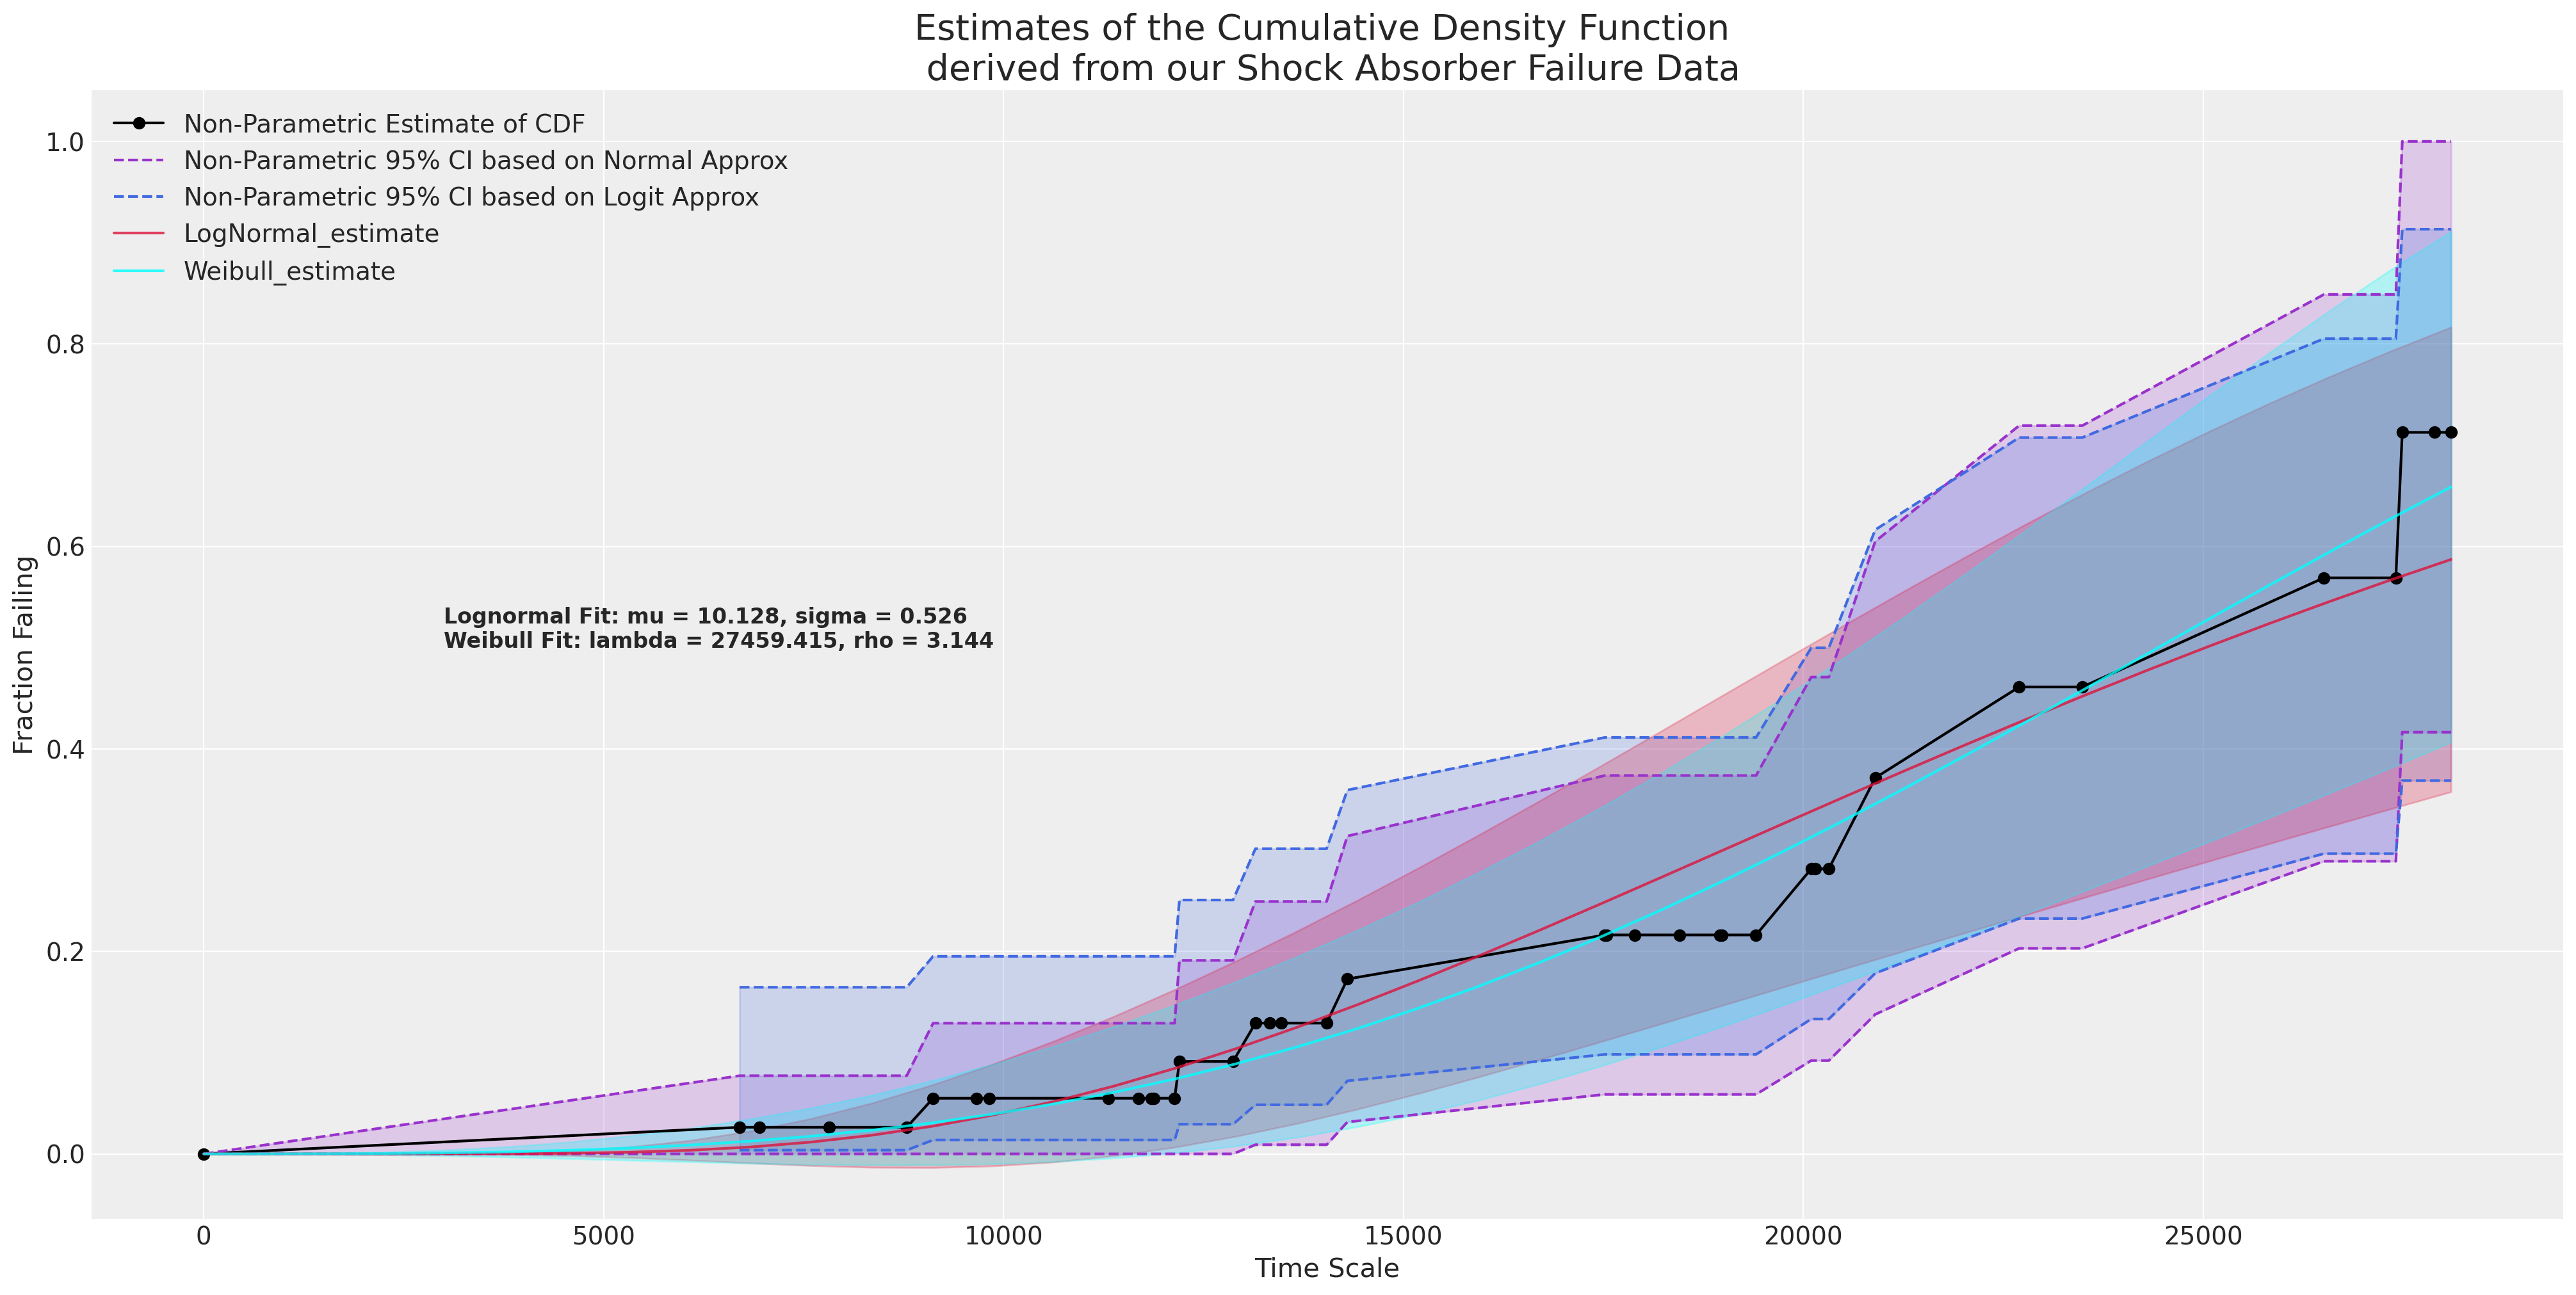

In [53]:
plot_cdfs(actuarial_table_shock, title="Shock Absorber");

#### The plug-in-procedure for calculating approximate statistical prediction intervals

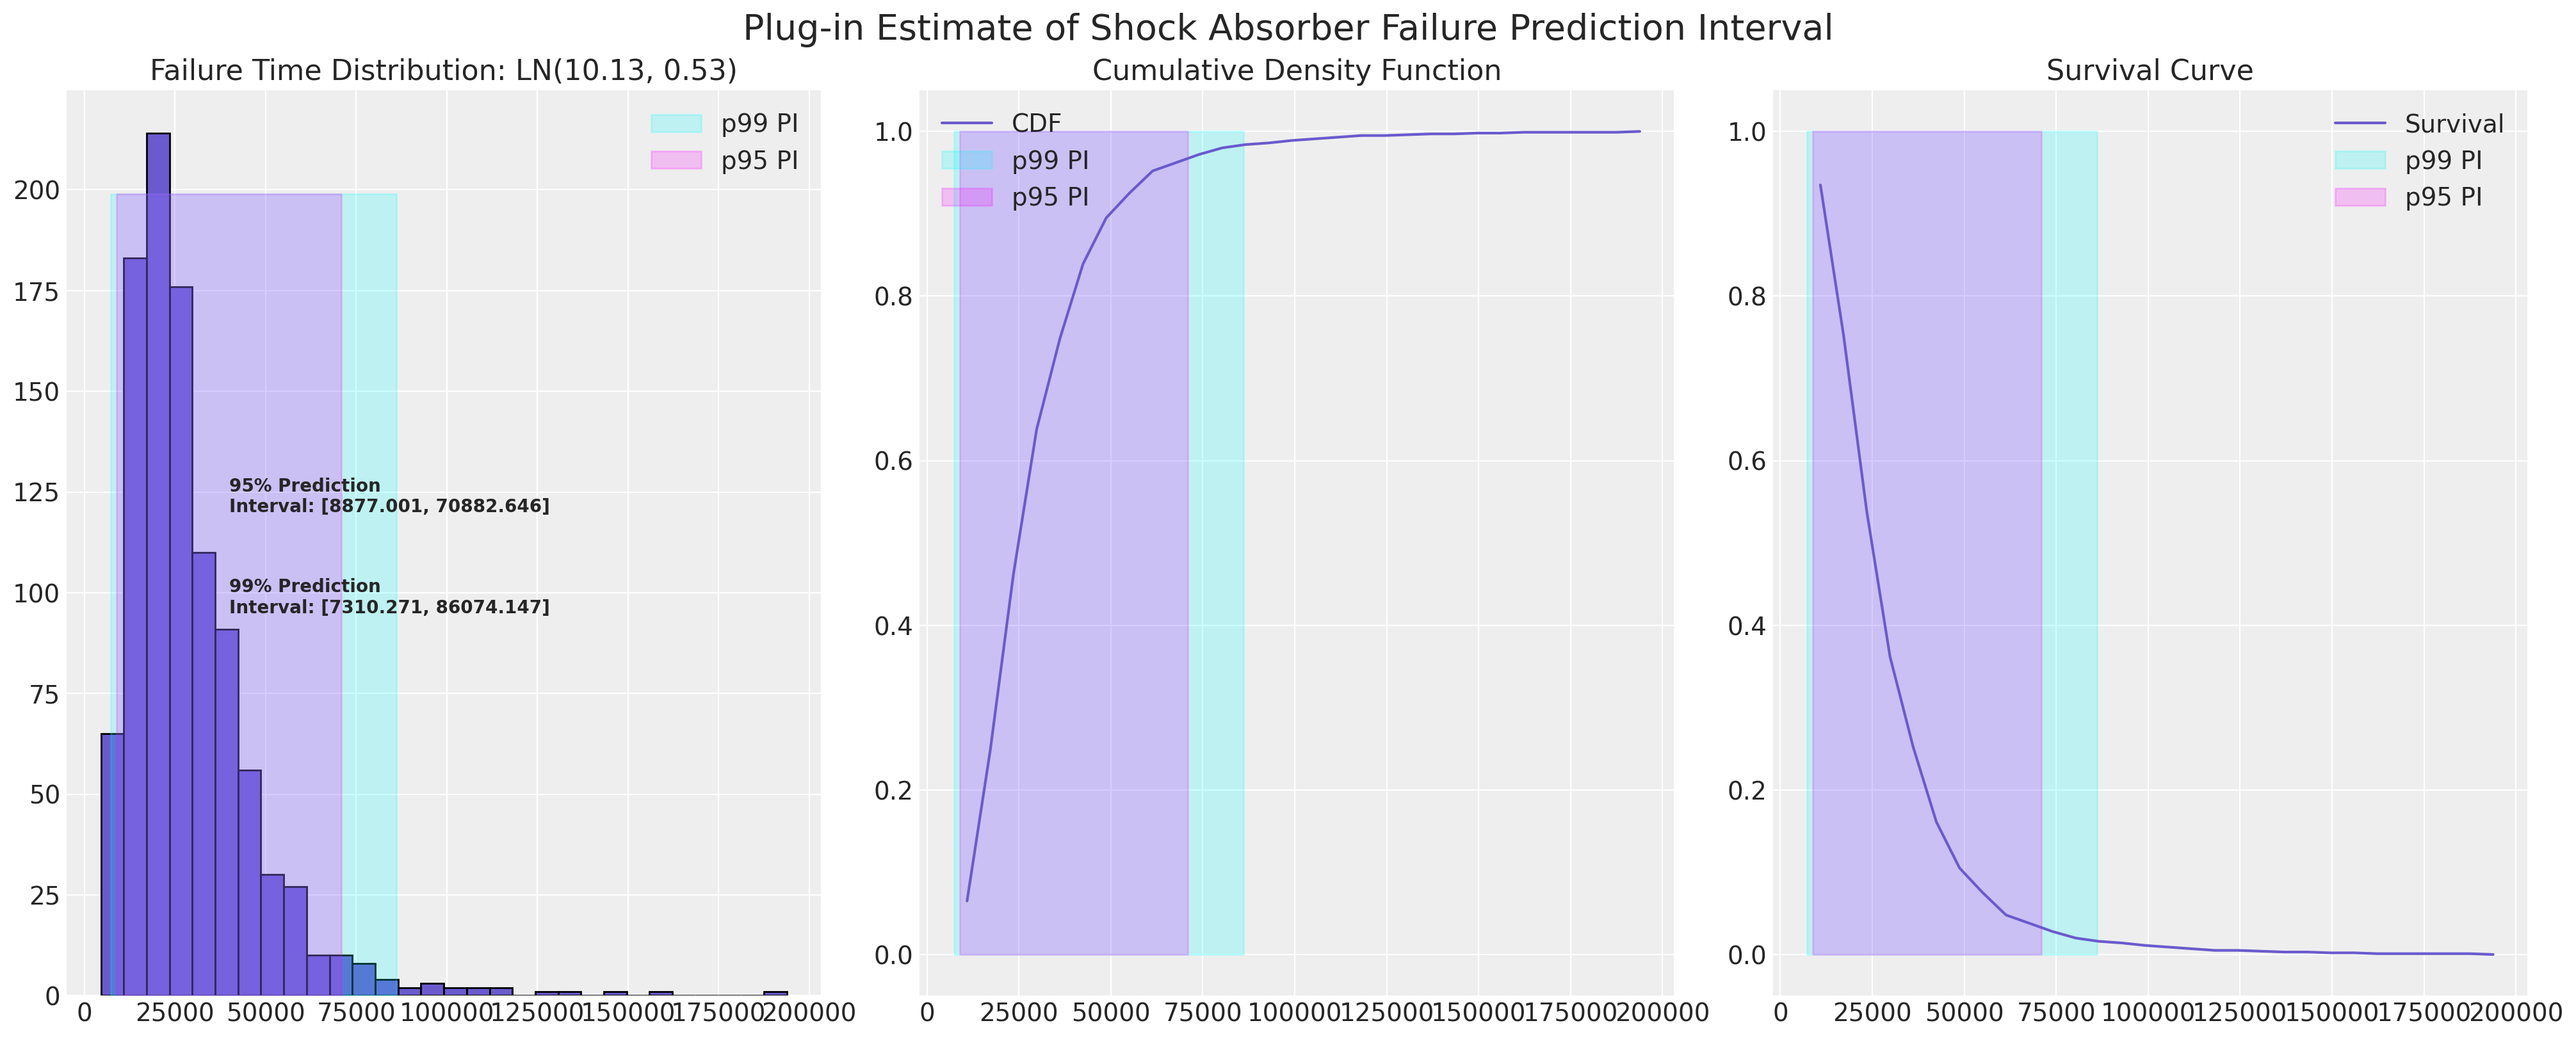

In [60]:
plot_ln_pi(
    round(lnf.mu_, 2),
    round(lnf.sigma_, 2),
    xy=(40000, 120),
    title="Plug-in Estimate of Shock Absorber Failure Prediction Interval",
)

#### Bootstrap calibration and coverage estimation

In [61]:
def bayes_boot(df, lb, ub, seed=100):
    w = np.random.dirichlet(np.ones(len(df)), 1)[0]
    lnf = LogNormalFitter().fit(df["t"] + 1e-25, df["failed"], weights=w)
    rv = lognorm(s=lnf.sigma_, scale=np.exp(lnf.mu_))
    ## Sample random choice from implied bootstrapped distribution
    choices = rv.rvs(1000)
    future = random.choice(choices)
    ## Check if choice is contained within the MLE 95% PI
    contained = (future >= lb) & (future <= ub)
    ## Record 95% interval of bootstrapped dist
    lb = rv.ppf(0.025)
    ub = rv.ppf(0.975)
    return lb, ub, contained, future, lnf.sigma_, lnf.mu_

In [62]:
CIs = [bayes_boot(actuarial_table_shock, 8928, 70188, seed=i) for i in range(1000)]
draws = pd.DataFrame(
    CIs, columns=["Lower Bound PI", "Upper Bound PI", "Contained", "future", "Sigma", "Mu"]
)
draws

Lower Bound PI  Upper Bound PI  Contained        future     Sigma  \
0      10182.762824    51129.405324       True  31982.685874  0.411656   
1       8350.758464    83153.955388       True  24040.958054  0.586322   
2       9858.795797    49583.077317       True  15238.221673  0.412070   
3      10722.848095    54646.279433       True  24335.171307  0.415442   
4       9172.641739    55028.693971       True  17175.637949  0.457057   
..              ...             ...        ...           ...       ...   
995     7818.692581    69223.535214       True   9294.280456  0.556343   
996    12445.795107    50656.811306       True  43932.465797  0.358091   
997     8465.914235    91450.170960       True  28536.449732  0.607089   
998     8283.497827    71829.115586      False   7790.634218  0.551037   
999     9729.942113    47210.471215       True  19688.833363  0.402918   

            Mu  
0    10.035283  
1    10.179278  
2    10.003762  
3    10.094384  
4    10.019795  
..         ...  
995  10.054684  
996  10.130984  
997  10.233676  
998  10.102033  
999   9.972667  

[1000 rows x 6 columns]

In [63]:
def ecdf(sample):
    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob

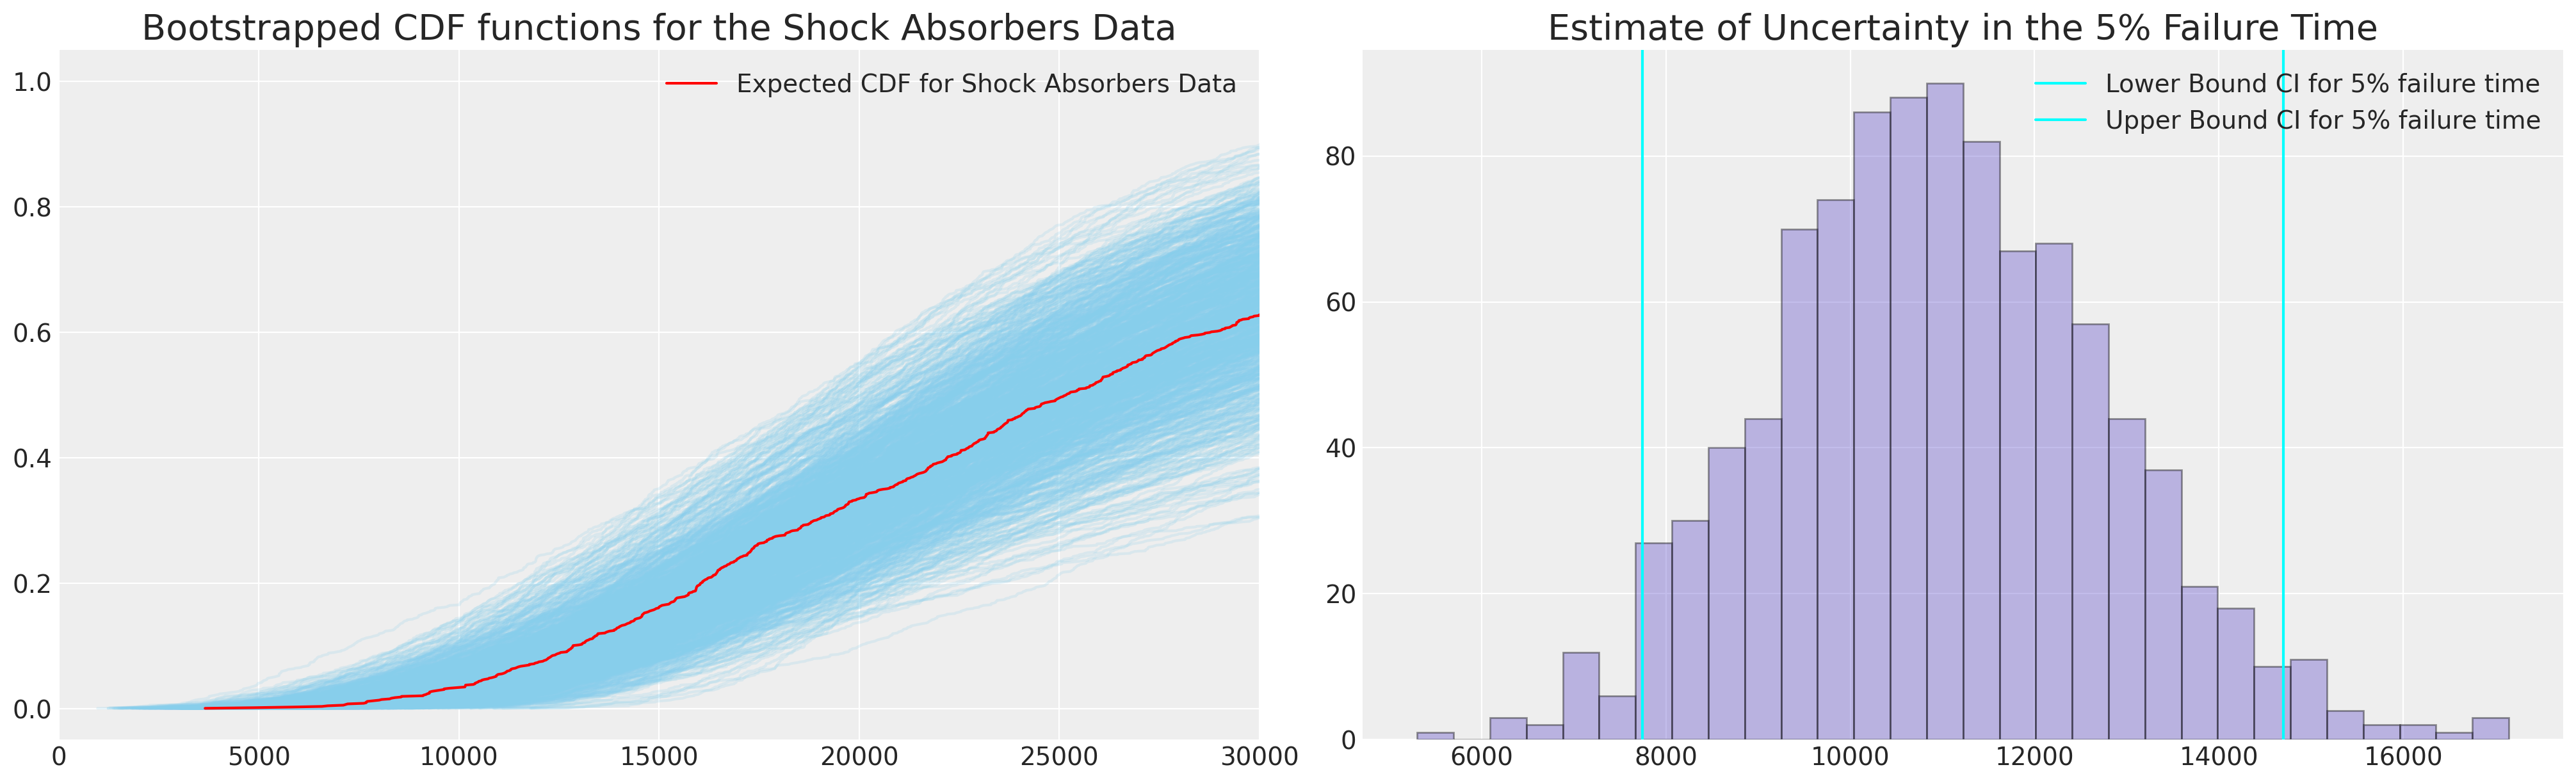

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
hist_data = []
for i in range(1000):
    samples = lognorm(s=draws.iloc[i]["Sigma"], scale=np.exp(draws.iloc[i]["Mu"])).rvs(1000)
    qe, pe = ecdf(samples)
    ax.plot(qe, pe, color="skyblue", alpha=0.2)
    lkup = dict(zip(pe, qe))
    hist_data.append([lkup[0.05]])
hist_data = pd.DataFrame(hist_data, columns=["p05"])
samples = lognorm(s=draws["Sigma"].mean(), scale=np.exp(draws["Mu"].mean())).rvs(1000)
qe, pe = ecdf(samples)
ax.plot(qe, pe, color="red", label="Expected CDF for Shock Absorbers Data")
ax.set_xlim(0, 30_000)
ax.set_title("Bootstrapped CDF functions for the Shock Absorbers Data", fontsize=20)
ax1.hist(hist_data["p05"], color="slateblue", ec="black", alpha=0.4, bins=30)
ax1.set_title("Estimate of Uncertainty in the 5% Failure Time", fontsize=20)
ax1.axvline(
    hist_data["p05"].quantile(0.025), color="cyan", label="Lower Bound CI for 5% failure time"
)
ax1.axvline(
    hist_data["p05"].quantile(0.975), color="cyan", label="Upper Bound CI for 5% failure time"
)
ax1.legend()
ax.legend();

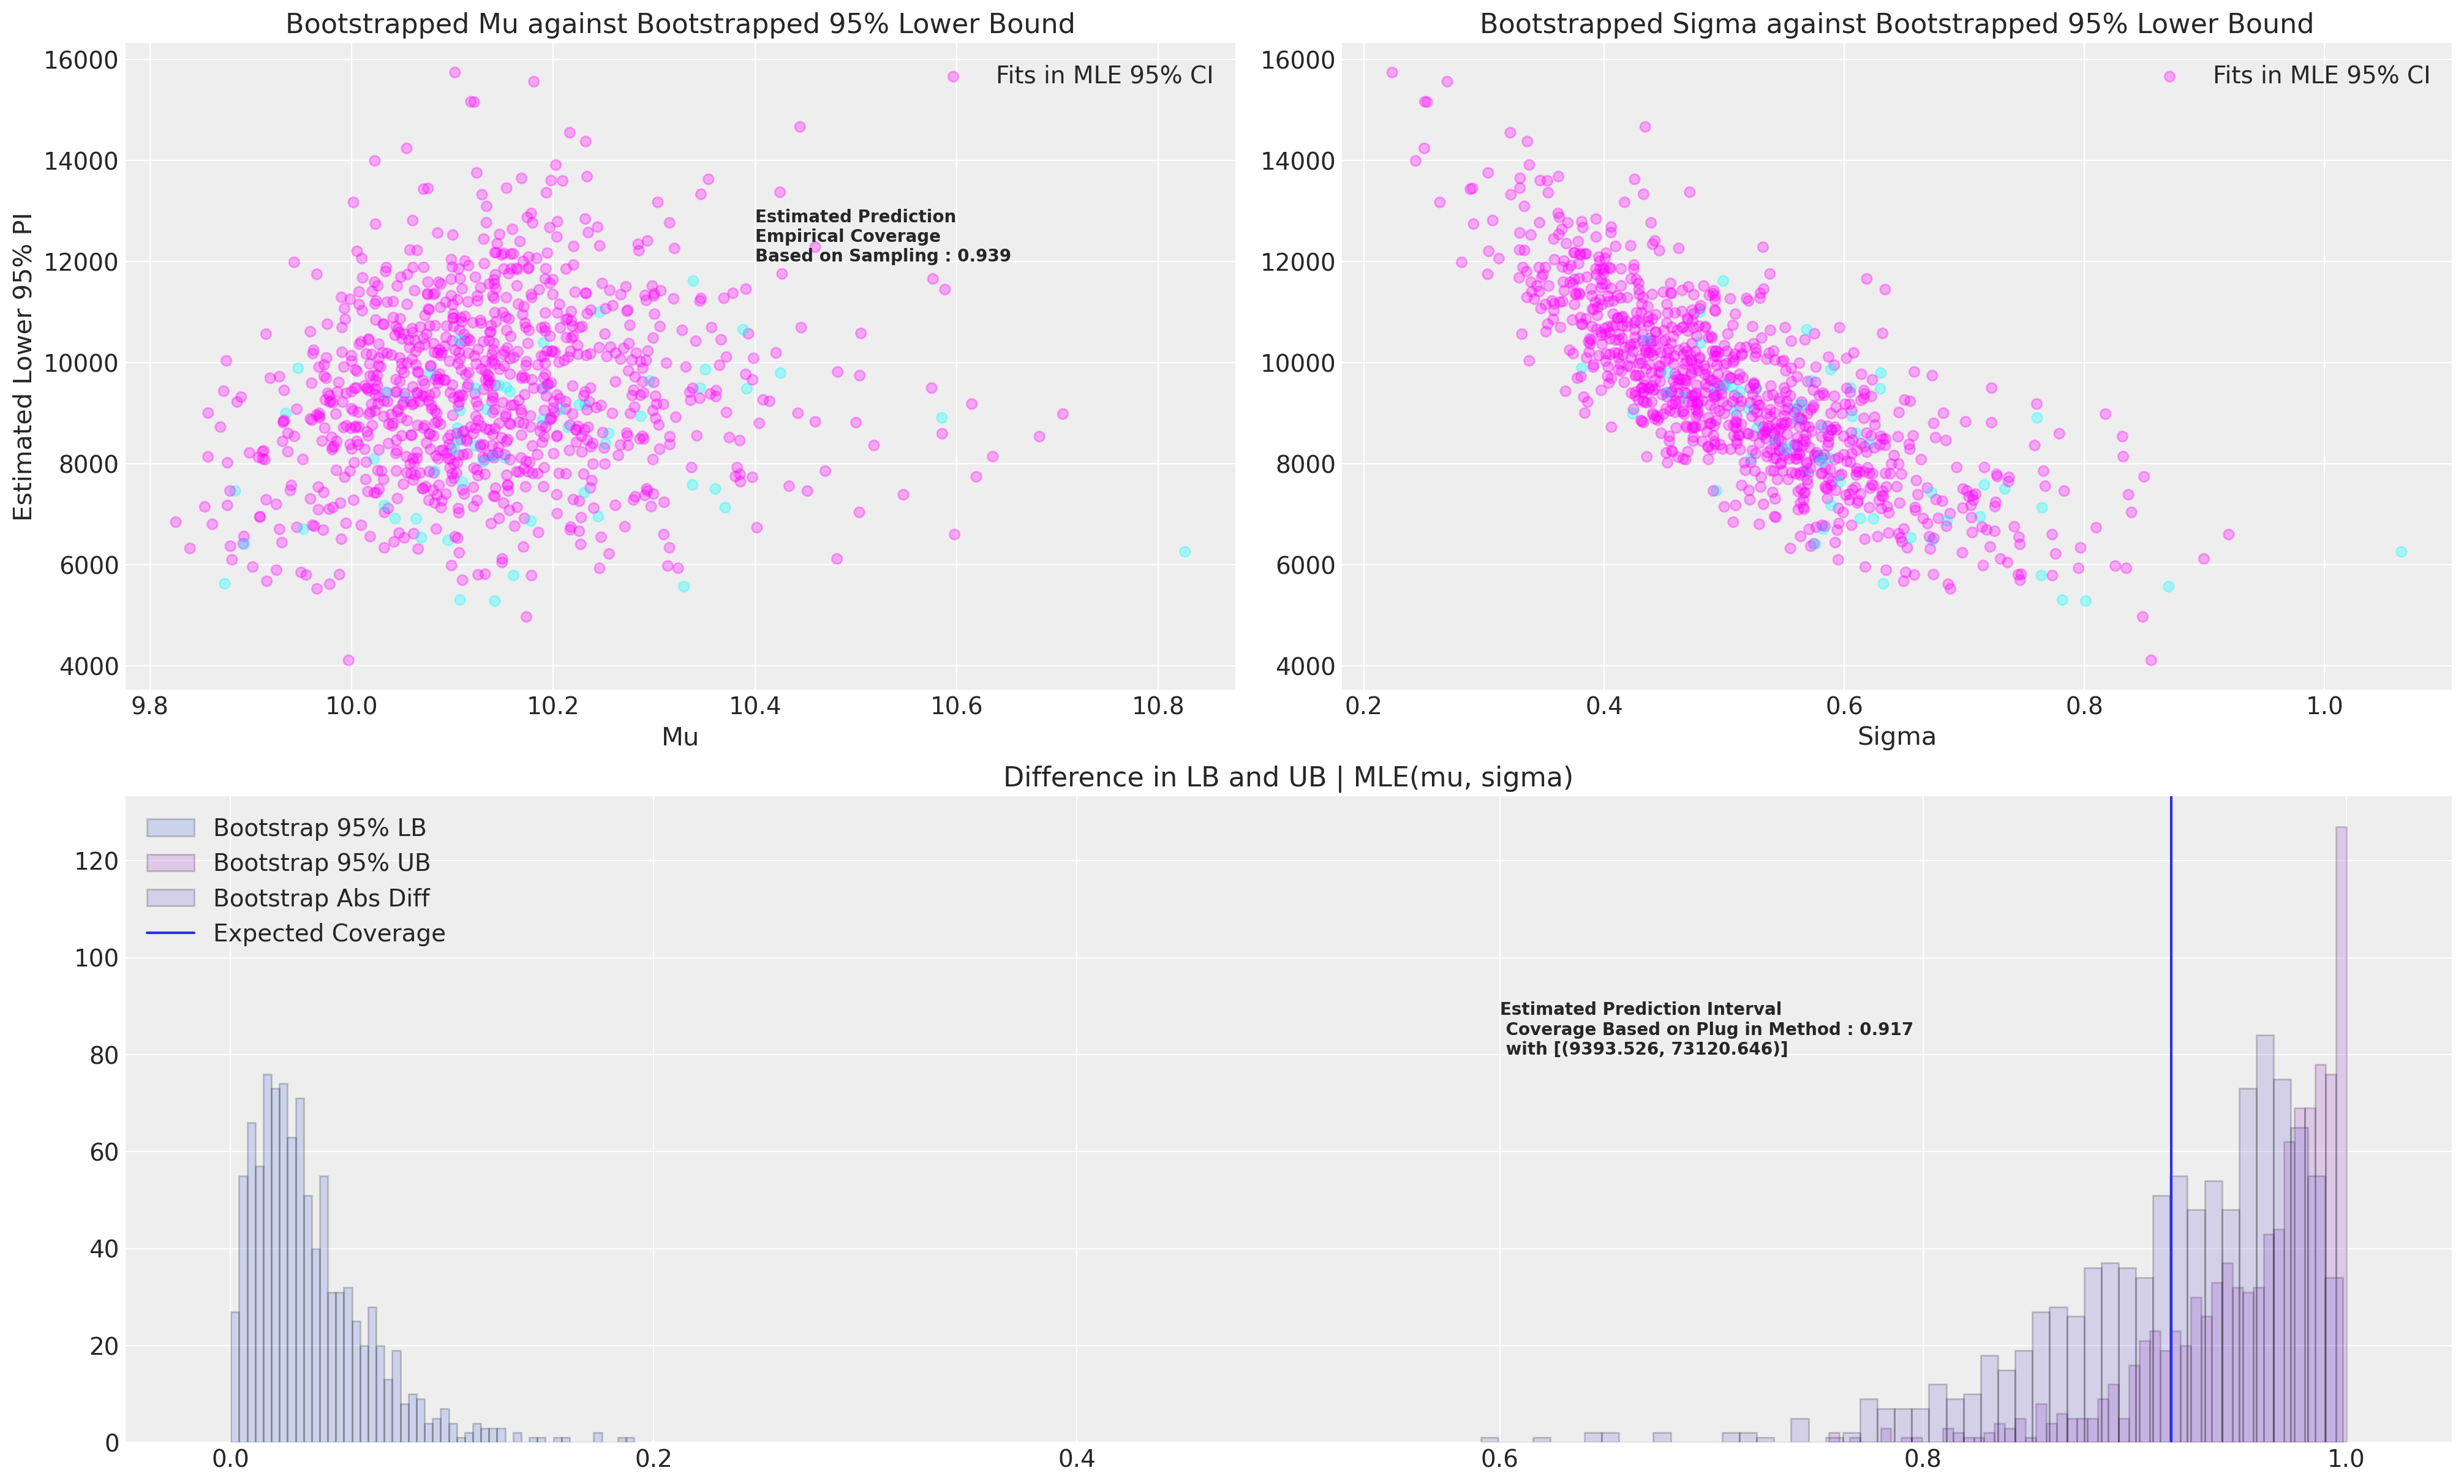

In [65]:
mosaic = """AABB
            CCCC"""
fig, axs = plt.subplot_mosaic(mosaic=mosaic, figsize=(20, 12))
mle_rv = lognorm(s=0.53, scale=np.exp(10.128))
axs = [axs[k] for k in axs.keys()]
axs[0].scatter(
    draws["Mu"],
    draws["Lower Bound PI"],
    c=draws["Contained"],
    cmap=cm.cool,
    alpha=0.3,
    label="Fits in MLE 95% CI",
)
axs[1].scatter(
    draws["Sigma"],
    draws["Lower Bound PI"],
    c=draws["Contained"],
    cmap=cm.cool,
    alpha=0.3,
    label="Fits in MLE 95% CI",
)
axs[0].set_title("Bootstrapped Mu against Bootstrapped 95% Lower Bound")
prop = draws["Contained"].sum() / len(draws)
axs[0].annotate(
    f"Estimated Prediction \nEmpirical Coverage \nBased on Sampling : {np.round(prop, 3)}",
    xy=(10.4, 12000),
    fontweight="bold",
)
axs[1].set_title("Bootstrapped Sigma against Bootstrapped 95% Lower Bound")
axs[0].legend()
axs[0].set_xlabel("Mu")
axs[1].set_xlabel("Sigma")
axs[0].set_ylabel("Estimated Lower 95% PI")
axs[1].legend()
axs[2].hist(
    mle_rv.cdf(draws["Lower Bound PI"]),
    bins=50,
    label="Bootstrap 95% LB",
    ec="k",
    color="royalblue",
    alpha=0.2,
)
axs[2].hist(
    mle_rv.cdf(draws["Upper Bound PI"]),
    bins=50,
    label="Bootstrap 95% UB",
    ec="k",
    color="darkorchid",
    alpha=0.2,
)
axs[2].hist(
    np.abs(mle_rv.cdf(draws["Lower Bound PI"]) - mle_rv.cdf(draws["Upper Bound PI"])),
    alpha=0.2,
    bins=50,
    color="slateblue",
    ec="black",
    label="Bootstrap Abs Diff",
)
axs[2].axvline(
    np.abs(mle_rv.cdf(draws["Lower Bound PI"]) - mle_rv.cdf(draws["Upper Bound PI"])).mean(),
    label="Expected Coverage",
)
axs[2].set_title("Difference in LB and UB | MLE(mu, sigma)")
axs[2].legend()

plug_in = np.abs(
    np.mean(mle_rv.cdf(draws["Lower Bound PI"])) - np.mean(mle_rv.cdf(draws["Upper Bound PI"]))
)
lb = np.round(draws["Lower Bound PI"].mean(), 3)
ub = np.round(draws["Upper Bound PI"].mean(), 3)
axs[2].annotate(
    f"Estimated Prediction Interval \n Coverage Based on Plug in Method : {np.round(plug_in, 3)} \n with [{lb, ub}]",
    xy=(0.6, 80),
    fontweight="bold",
);

### Bearing cage data: a study in bayesian reliability data

In [66]:
bearing_cage_df = pd.read_csv(
    StringIO(
        """Hours,Censoring Indicator,Count
50,Censored,288
150,Censored,148
230,Failed,1
250,Censored,124
334,Failed,1
350,Censored,111
423,Failed,1
450,Censored,106
550,Censored,99
650,Censored,110
750,Censored,114
850,Censored,119
950,Censored,127
990,Failed,1
1009,Failed,1
1050,Censored,123
1150,Censored,93
1250,Censored,47
1350,Censored,41
1450,Censored,27
1510,Failed,1
1550,Censored,11
1650,Censored,6
1850,Censored,1
2050,Censored,2"""
    )
)

In [67]:
bearing_cage_df["t"] = bearing_cage_df["Hours"]
bearing_cage_df["failed"] = np.where(bearing_cage_df["Censoring Indicator"] == "Failed", 1, 0)
bearing_cage_df["censored"] = np.where(
    bearing_cage_df["Censoring Indicator"] == "Censored", bearing_cage_df["Count"], 0
)
bearing_cage_events = survival_table_from_events(
    bearing_cage_df["t"], bearing_cage_df["failed"], weights=bearing_cage_df["Count"]
).reset_index()
bearing_cage_events.rename(
    {"event_at": "t", "observed": "failed", "at_risk": "risk_set"}, axis=1, inplace=True
)

In [68]:
actuarial_table_bearings = make_actuarial_table(bearing_cage_events)

actuarial_table_bearings

t  removed  failed  censored  entrance  risk_set     p_hat   1-p_hat  \
0      0.0        0       0         0      1703      1703  0.000000  1.000000   
1     50.0      288       0       288         0      1703  0.000000  1.000000   
2    150.0      148       0       148         0      1415  0.000000  1.000000   
3    230.0        1       1         0         0      1267  0.000789  0.999211   
4    250.0      124       0       124         0      1266  0.000000  1.000000   
5    334.0        1       1         0         0      1142  0.000876  0.999124   
6    350.0      111       0       111         0      1141  0.000000  1.000000   
7    423.0        1       1         0         0      1030  0.000971  0.999029   
8    450.0      106       0       106         0      1029  0.000000  1.000000   
9    550.0       99       0        99         0       923  0.000000  1.000000   
10   650.0      110       0       110         0       824  0.000000  1.000000   
11   750.0      114       0       114         0       714  0.000000  1.000000   
12   850.0      119       0       119         0       600  0.000000  1.000000   
13   950.0      127       0       127         0       481  0.000000  1.000000   
14   990.0        1       1         0         0       354  0.002825  0.997175   
15  1009.0        1       1         0         0       353  0.002833  0.997167   
16  1050.0      123       0       123         0       352  0.000000  1.000000   
17  1150.0       93       0        93         0       229  0.000000  1.000000   
18  1250.0       47       0        47         0       136  0.000000  1.000000   
19  1350.0       41       0        41         0        89  0.000000  1.000000   
20  1450.0       27       0        27         0        48  0.000000  1.000000   
21  1510.0        1       1         0         0        21  0.047619  0.952381   
22  1550.0       11       0        11         0        20  0.000000  1.000000   
23  1650.0        6       0         6         0         9  0.000000  1.000000   
24  1850.0        1       0         1         0         3  0.000000  1.000000   
25  2050.0        2       0         2         0         2  0.000000  1.000000   

       S_hat    CH_hat     F_hat         V_hat  Standard_Error  CI_95_lb  \
0   1.000000 -0.000000  0.000000  0.000000e+00        0.000000       0.0   
1   1.000000 -0.000000  0.000000  0.000000e+00        0.000000       0.0   
2   1.000000 -0.000000  0.000000  0.000000e+00        0.000000       0.0   
3   0.999211  0.000790  0.000789  6.224491e-07        0.000789       0.0   
4   0.999211  0.000790  0.000789  6.224491e-07        0.000789       0.0   
5   0.998336  0.001666  0.001664  1.386254e-06        0.001177       0.0   
6   0.998336  0.001666  0.001664  1.386254e-06        0.001177       0.0   
7   0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
8   0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
9   0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
10  0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
11  0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
12  0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
13  0.997367  0.002637  0.002633  2.322113e-06        0.001524       0.0   
14  0.994549  0.005466  0.005451  1.022444e-05        0.003198       0.0   
15  0.991732  0.008303  0.008268  1.808196e-05        0.004252       0.0   
16  0.991732  0.008303  0.008268  1.808196e-05        0.004252       0.0   
17  0.991732  0.008303  0.008268  1.808196e-05        0.004252       0.0   
18  0.991732  0.008303  0.008268  1.808196e-05        0.004252       0.0   
19  0.991732  0.008303  0.008268  1.808196e-05        0.004252       0.0   
20  0.991732  0.008303  0.008268  1.808196e-05        0.004252       0.0   
21  0.944506  0.057093  0.055494  2.140430e-03        0.046265       0.0   
22  0.944506  0.057093  0.055494  2.140430e-03        0.046265       0.0 

In [69]:
item_period = bearing_cage_df["Hours"].to_list() * bearing_cage_df["Count"].sum()
ids = [[i] * 25 for i in range(bearing_cage_df["Count"].sum())]
ids = [int(i) for l in ids for i in l]
item_period_bearing_cage = pd.DataFrame(item_period, columns=["t"])
item_period_bearing_cage["id"] = ids
item_period_bearing_cage["failed"] = np.zeros(len(item_period_bearing_cage))

In [70]:
## Censor appropriate number of ids
unique_ids = item_period_bearing_cage["id"].unique()
censored = bearing_cage_df[bearing_cage_df["Censoring Indicator"] == "Censored"]
i = 0
stack = []
for hour, count, idx in zip(censored["Hours"], censored["Count"], censored["Count"].cumsum()):
    temp = item_period_bearing_cage[
        item_period_bearing_cage["id"].isin(unique_ids[i:idx])
        & (item_period_bearing_cage["t"] == hour)
    ]
    stack.append(temp)
    i = idx

censored_clean = pd.concat(stack)

In [71]:
### Add  appropriate number of failings
stack = []
unique_times = censored_clean["t"].unique()
for id, fail_time in zip(
    [9999, 9998, 9997, 9996, 9995, 9994],
    bearing_cage_df[bearing_cage_df["failed"] == 1]["t"].values,
):
    temp = pd.DataFrame(unique_times[unique_times < fail_time], columns=["t"])
    temp["id"] = id
    temp["failed"] = 0
    temp = pd.concat([temp, pd.DataFrame({"t": [fail_time], "id": [id], "failed": [1]}, index=[0])])
    stack.append(temp)

failed_clean = pd.concat(stack).sort_values(["id", "t"])
censored_clean
item_period_bearing_cage = pd.concat([failed_clean, censored_clean])

In [72]:
## Transpose for more concise visual
item_period_bearing_cage.head(30).T

0       1       2       3       4       5       6       7  \
t         50.0   150.0   250.0   350.0   450.0   550.0   650.0   750.0   
id      9994.0  9994.0  9994.0  9994.0  9994.0  9994.0  9994.0  9994.0   
failed     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

             8       9  ...       4       5       6       7       8       9  \
t        850.0   950.0  ...   450.0   550.0   650.0   750.0   850.0   950.0   
id      9994.0  9994.0  ...  9995.0  9995.0  9995.0  9995.0  9995.0  9995.0   
failed     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

             0       0       1       2  
t       1009.0    50.0   150.0   250.0  
id      9995.0  9996.0  9996.0  9996.0  
failed     1.0     0.0     0.0     0.0  

[3 rows x 30 columns]

In [73]:
assert item_period_bearing_cage["id"].nunique() == 1703
assert item_period_bearing_cage["failed"].sum() == 6
assert item_period_bearing_cage[item_period_bearing_cage["t"] >= 1850]["id"].nunique() == 3

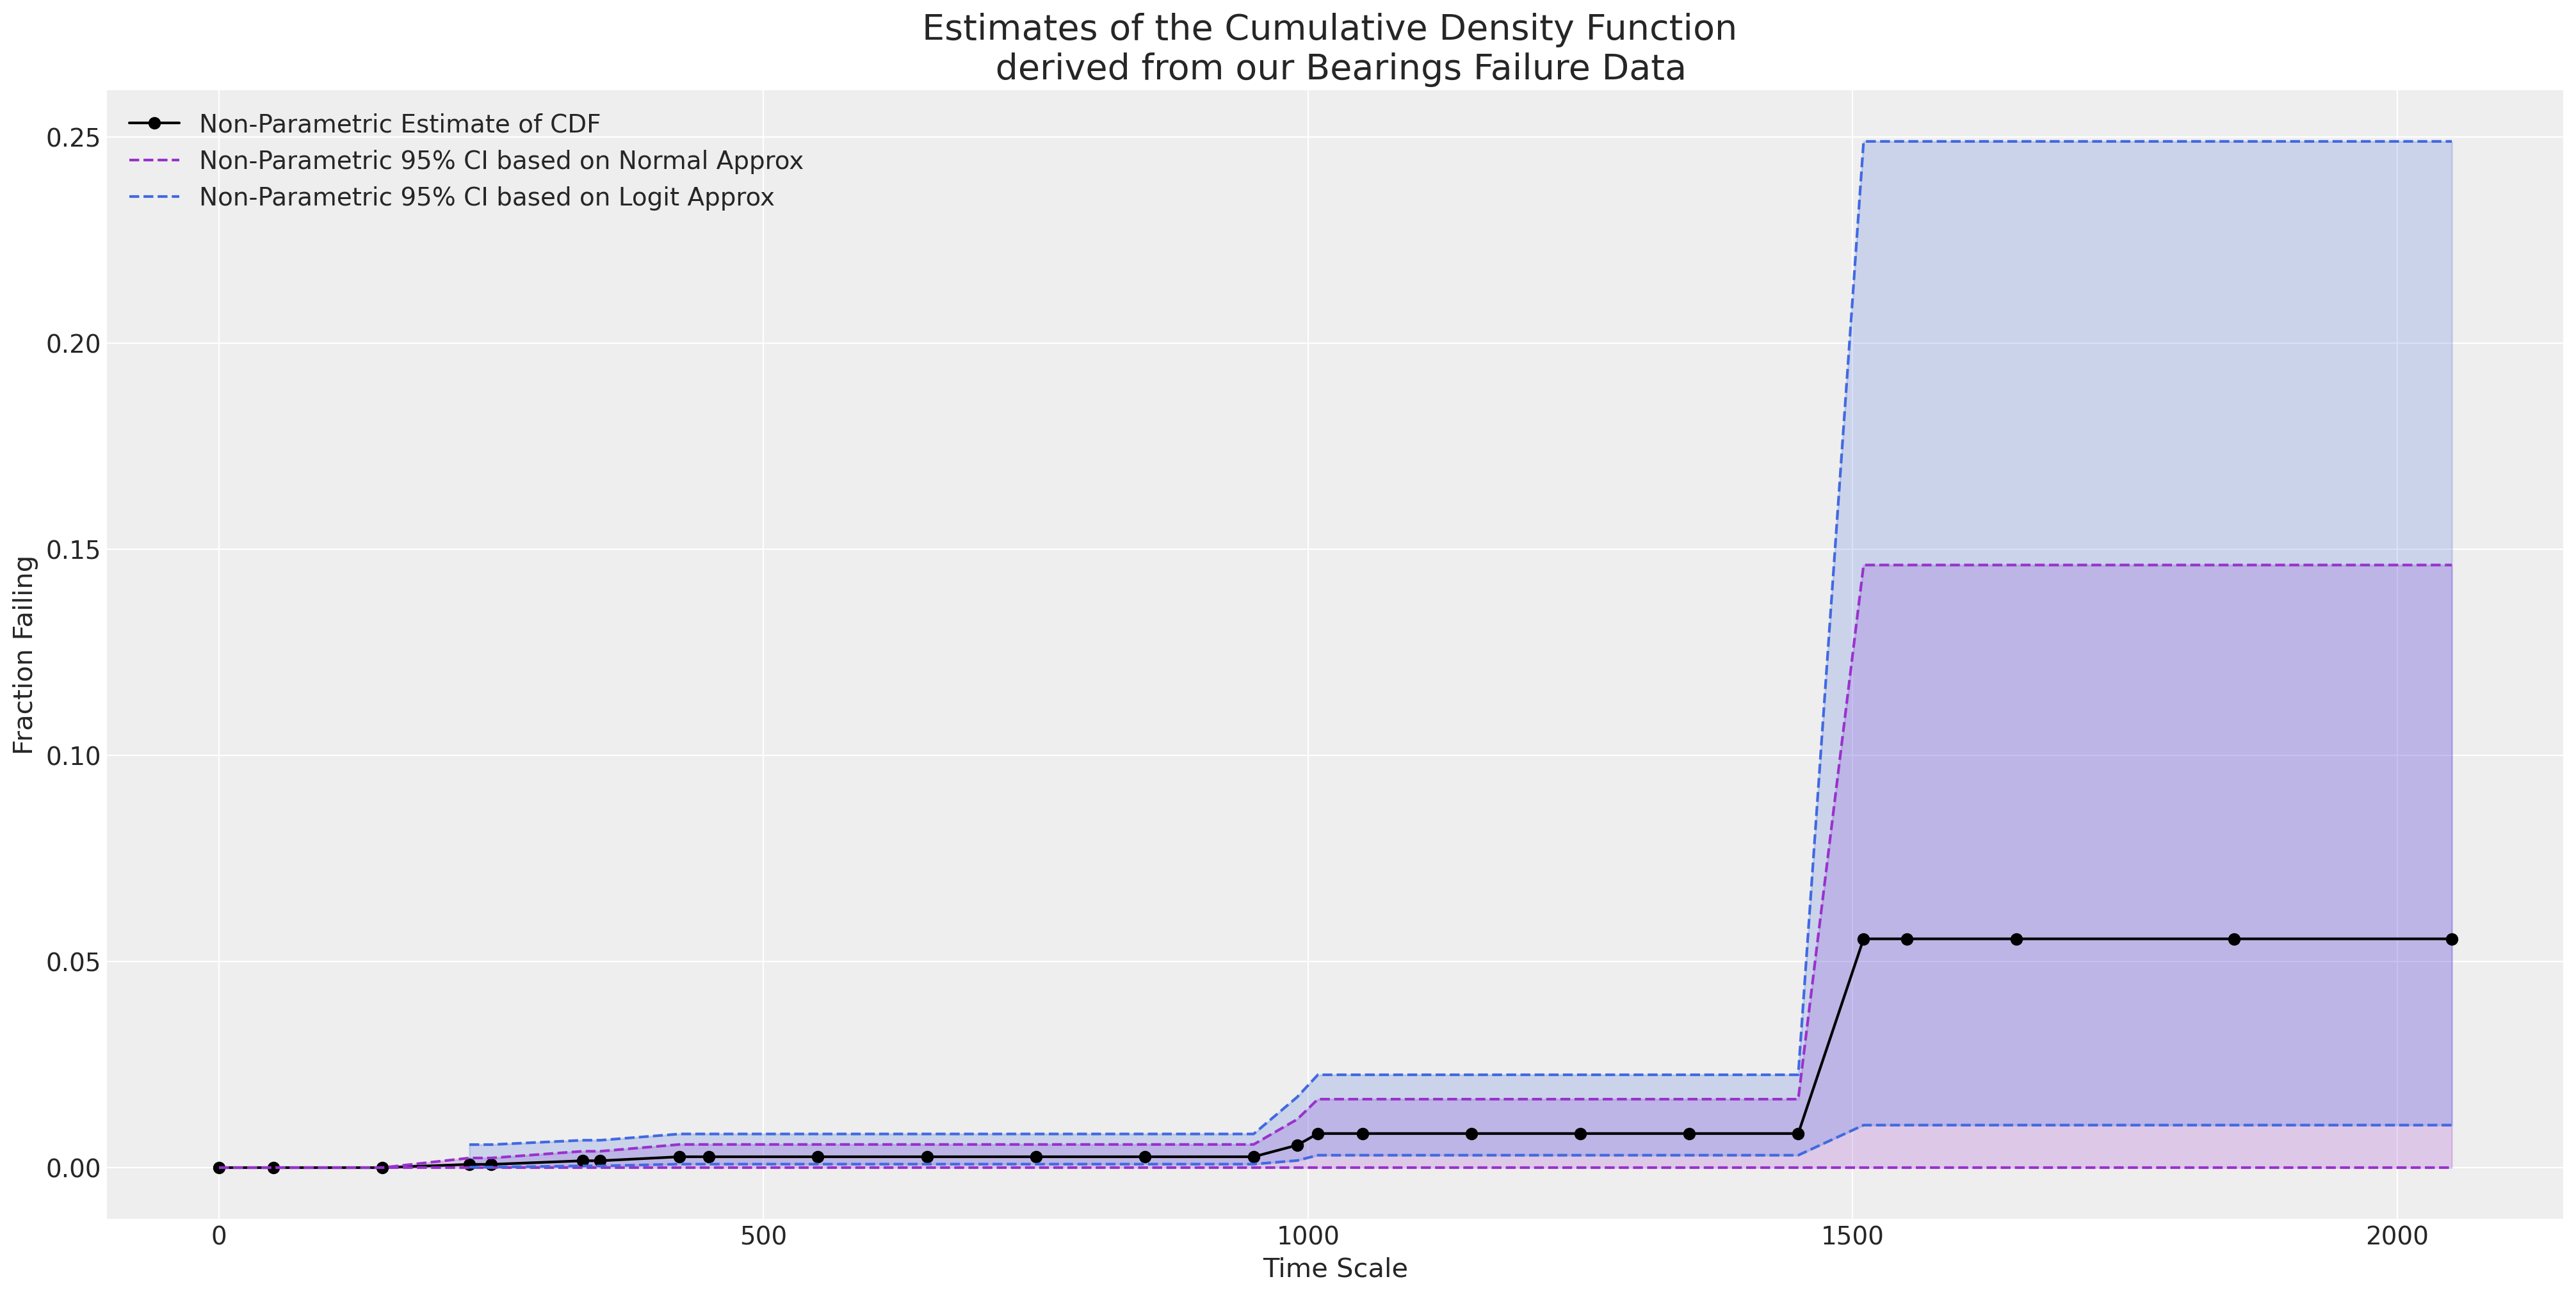

In [74]:
ax = plot_cdfs(
    actuarial_table_bearings,
    title="Bearings",
    dist_fits=False,
    xy=(20, 0.7),
    item_period=item_period_bearing_cage,
)